In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Image Classification with Convolutional Neural Networks

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rses-dl-course/rses-dl-course.github.io/blob/master/notebooks/R/R03_image_classification_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/rses-dl-course/rses-dl-course.github.io/blob/master/notebooks/R/R03_image_classification_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this tutorial, we'll build and train a neural network to classify images of clothing, like sneakers and shirts.

It's okay if you don't understand everything. This is a fast-paced overview of a complete TensorFlow program, with explanations along the way. The goal is to get the general sense of a TensorFlow project, not to catch every detail.

This guide uses the [keras](https://keras.rstudio.com/) R package, a high-level API to build and train models in TensorFlow.

## Install and import dependencies

We'll need to install the `keras` R package which also includes the example datasets we'll be working with.

In [ ]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Once installed, load the library

In [ ]:
library(keras)

Let's also install a few more packages we will need, mainly for plotting

In [ ]:
install.packages(c("ggplot2", "cowplot"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 $\times$ 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from the [Keras R package](https://keras.rstudio.com/reference/dataset_fashion_mnist.html) using:

In [ ]:
fashion_mnist <- dataset_fashion_mnist()
str(fashion_mnist)

List of 2
 $ train:List of 2
  ..$ x: int [1:60000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:60000(1d)] 9 0 0 3 0 2 7 2 5 5 ...
 $ test :List of 2
  ..$ x: int [1:10000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:10000(1d)] 9 2 1 1 6 1 4 6 5 7 ...


Loading the dataset returns a list of length 2 containing the training (`train`) and testing (`test`) datasets. 
* The model is trained using `train` dataset.
* The model is tested against `test` dataset.

Each dataset contains images (`x`) and their associated labels (`y`). We can separate our data into appropriately named objects to work with using the `%<-%` assignment operator.  

In [ ]:
c(train_images, train_labels) %<-% fashion_mnist$train
c(test_images, test_labels) %<-% fashion_mnist$test

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. 

In [ ]:
str(train_images)

 int [1:60000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...


The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

In [ ]:
str(train_labels)

 int [1:60000(1d)] 9 0 0 3 0 2 7 2 5 5 ...


Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [ ]:
class_names <- c('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',  'Shirt',   'Sneaker',  'Bag',   'Ankle boot')
num_classes <- length(class_names)

### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels.

In [ ]:
dim(train_images)

[1] 60000    28    28

The pixel values across all images range between 0 and 255

In [ ]:
range(train_images)

[1]   0 255

Likewise, there are 60,000 labels in the training set:

In [ ]:
dim(train_labels)

[1] 60000

Each label is an integer between 0 and 9:

In [ ]:
train_labels %>% unique() %>% sort()

[1] 0 1 2 3 4 5 6 7 8 9

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [ ]:
dim(test_images)

[1] 10000    28    28

And the test set contains 10,000 images labels:

In [ ]:
dim(test_labels)

[1] 10000

## Preprocess the data

The data must be preprocessed before training the network. The value of each pixel in the image data is an integer in the range `[0,255]`. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

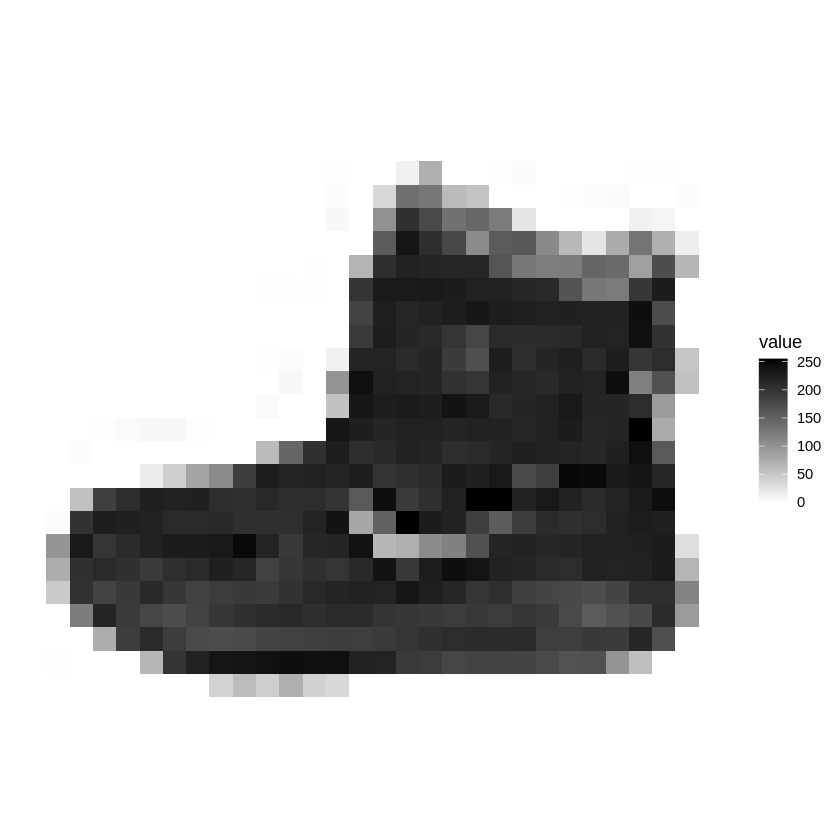

In [ ]:
library(tidyr)
library(ggplot2)

plot_fashionmnist_image <- function(image){
  image <- as.data.frame(image)
  colnames(image) <- seq_len(ncol(image))
  image$y <- seq_len(nrow(image))
  image <- gather(image, "x", "value", -y)
  image$x <- as.integer(image$x)

  ggplot(image, aes(x = x, y = y, fill = value)) +
    geom_tile() +
    scale_fill_gradient(low = "white", high = "black", na.value = NA) +
    scale_y_reverse() +
    theme_minimal() +
          theme(panel.grid = element_blank(), 
                axis.text = element_blank(),
                axis.title = element_blank(),
                aspect.ratio = 1)
}

plot_fashionmnist_image(train_images[1,,])

For the model to work properly, these values need to be normalized to the range `[0,1]`. To perform the conversion we can divide each array by 255.

In [ ]:
train_images <- train_images/255
test_images <- test_images/255

Keras models are optimized to make predictions on a batch, or collection, of examples at once. So we need to add another dimension for batching

In [ ]:
train_images <- array_reshape(train_images, c(nrow(train_images), 28, 28, 1))
test_images <- array_reshape(test_images, c(nrow(test_images), 28, 28, 1))

### Explore the processed data

We can check that pixel values have been successfully processed by checking the range of values in each array.

In [ ]:
range(train_images)
range(test_images)

[1] 0 1

[1] 0 1

To verify that the data appears correctly labelled, let's also display the first 25 images from the training set as well as the class name below each image.

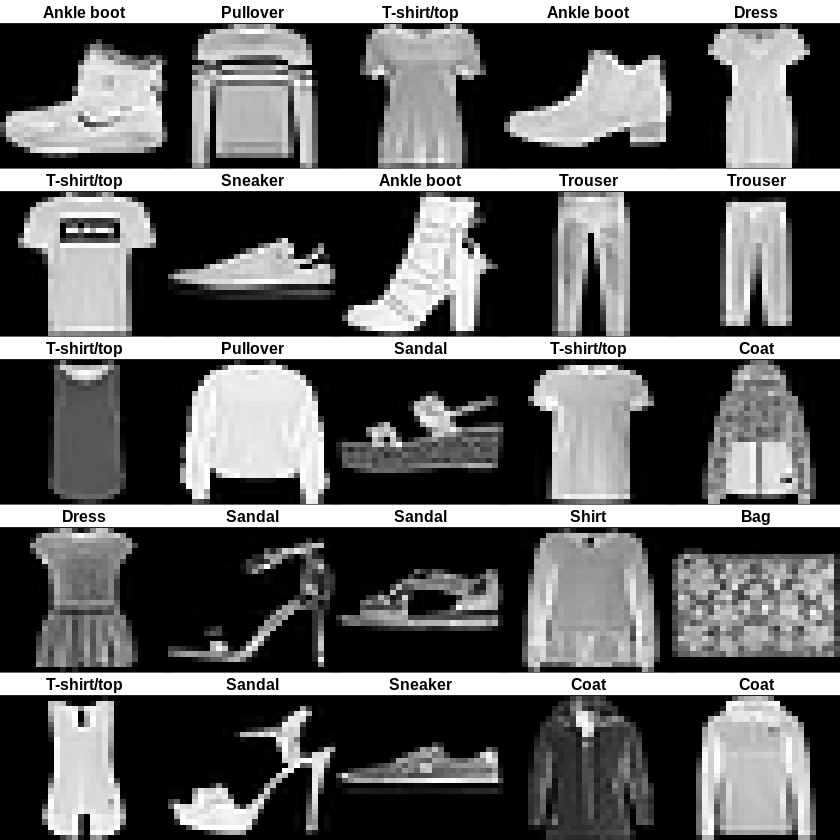

In [ ]:
par(mfcol=c(5,5))
par(mar=c(0, 0, 1.5, 0), xaxs='i', yaxs='i')
for (i in 1:25) { 
  img <- train_images[i, , , ]
  img <- t(apply(img, 2, rev)) 
  image(1:28, 1:28, img, col = gray((0:255)/255), xaxt = 'n', yaxt = 'n',
        main = paste(class_names[train_labels[i] + 1]))
}

Let's also check we have the correct dimensions in our data for training, which should be 4.

In [ ]:
dim(train_images)
dim(test_images)

[1] 60000    28    28     1

[1] 10000    28    28     1

We’re ready to build and train the network!

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like Keras `layer_dense`, have internal parameters which are adjusted ("learned") during training.

In [ ]:
model <- keras_model_sequential()
model %>% 
  layer_conv_2d(filters = 32, kernel_size = c(3,3), padding = 'same', 
    activation = 'relu', input_shape = c(28, 28, 1)) %>%
  layer_max_pooling_2d(pool_size = c(2, 2), strides = 2) %>%
  layer_conv_2d(filters = 64, kernel_size = c(3,3), padding = 'same', 
    activation = 'relu') %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%   
  layer_flatten() %>% 
  layer_dense(units = 128, activation = 'relu') %>% 
  layer_dense(units = 10, activation = 'softmax')


In [ ]:
model

Model
Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_1 (Conv2D)                   (None, 28, 28, 32)              320         
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 14, 14, 32)              0           
________________________________________________________________________________
conv2d (Conv2D)                     (None, 14, 14, 64)              18496       
________________________________________________________________________________
max_pooling2d (MaxPooling2D)        (None, 7, 7, 64)                0           
________________________________________________________________________________
flatten (Flatten)                   (None, 3136)                    0           
________________________________________________________________________________
de

This network layers are:

* **"convolutions"** `layer_conv_2d` and `max_pooling_2d`— Network start with two pairs of Conv/MaxPool layers. The first layer is a `conv_2d` layer with (3,3) filters being applied to the input image, retaining the original image size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 outputs are reduced in size using a `max_pooling_2d` (2,2) with a stride of 2. The next `conv_2d` also has a (3,3) kernel, takes the 32 images as input and creates 64 outputs which are again reduced in size by a `max_pooling_2d` layer. So far in the course, we have described what a Convolution does, but we haven't yet covered how you chain multiples of these together. We will get back to this in lesson 4 when we use color images. At this point, it's enough if you understand the kind of operation a convolutional filter performs

* **output** `layer_dense` — A 128-neuron layer, followed by 10-node *softmax* layer. Each node in the final layer represents a class of clothing. The final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [ ]:
model %>% compile(
  loss = loss_sparse_categorical_crossentropy,
  optimizer = optimizer_adam(),
  metrics = c('accuracy')
)

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `fit()` method:
1. Feed the training data to the model using `x_train` & `y_train`.
2. The model learns to associate images and labels.
3. The `epochs = 5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

(Don't worry about `steps_per_epoch`, the requirement to have this flag will soon be removed.)

In [ ]:
history <- model %>% fit(
  x = train_images, y = train_labels,
  batch_size = 32,
  epochs = 10,
  validation_split = 0.2,
  verbose = 2
)

`geom_smooth()` using formula 'y ~ x'



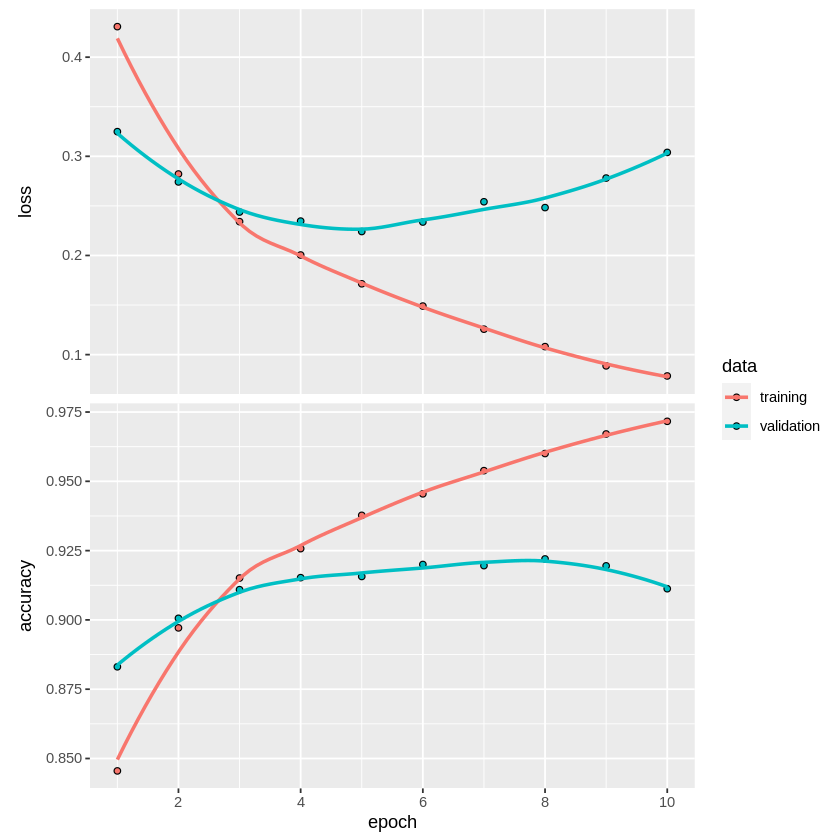

In [ ]:
plot(history)

In [ ]:
scores <- model %>% evaluate(
  test_images, test_labels, verbose = 1
)

# Output metrics
cat('Test loss:', scores[[1]], '\n')
cat('Test accuracy:', scores[[2]], '\n')

Test loss: 0.3169832 
Test accuracy: 0.9085 


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down. 

## Make predictions and explore

With the model trained, we can use it to make predictions about some images. Let's subset the first 32 images and labels from the test dataset.

In [ ]:
pred_images <- test_images[1:32 , , , , drop = FALSE]
pred_labels <- test_labels[1:32]

Next we can use use our model and the keras `predict` function to generate some predictions for our image subset

In [ ]:
preds_probs <- model %>%
  predict(x = pred_images)

head(preds_probs)

1.193397e-09,1.458969e-16,3.230989e-10,2.130613e-11,3.533129e-10,7.612671e-07,4.457721e-11,1.655595e-08,1.727925e-12,9.999992e-01
3.246128e-06,1.773643e-17,9.999967e-01,1.267415e-10,4.130504e-09,2.520271e-15,1.501813e-07,1.397643e-20,8.817327e-14,2.570566e-16
6.335018e-14,1.000000e+00,7.680040e-13,2.460442e-11,2.290846e-17,5.958157e-19,2.677363e-16,7.354577e-23,3.173862e-15,1.513431e-22
2.216004e-12,1.000000e+00,1.717766e-12,5.084172e-09,1.544394e-15,1.744945e-18,2.993424e-12,2.898957e-21,3.333561e-14,1.669898e-18
3.633683e-01,2.681879e-10,7.545993e-04,4.172435e-05,3.613222e-04,1.135314e-08,6.354740e-01,2.137130e-09,4.493621e-08,4.867037e-08
3.447333e-14,1.000000e+00,1.783979e-11,1.537945e-10,9.691302e-15,1.635776e-18,1.242001e-16,1.469327e-21,2.218818e-14,6.127667e-20


Here, the model has calculated the probability associated with each label for each image in our subset and returns a matrix with 10 columns (the number of classes) and 32 rows (the number of images in our subset. Note that we have only printed out the top 6 rows above).

To get a class prediction we select the class (column) with the highest probability. We can do that by applying the `which.max` function to each row of our prediction matrix. We also need to subtract 1 from each returned column index because while column indexes are 1 indexed (the first column number is indexed by 1), our classes are 0 indexed (the first class in our data is indexed with 0).

In [ ]:
apply(preds_probs, 1, which.max) - 1

[1] 9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 6 8 0 2 5 7 5 1 4 6 0 9 3 8 8

This prediction approach can be useful if you want to know the probability distribution for each prediction across all classes. However, if you are only interested in the predicted class, there is a shorthand keras function that can return predicted classes instead, `predict_classes`. 

In [ ]:
preds_classes <- model %>%
  predict_classes(x = pred_images)

preds_classes

[1] 9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 6 8 0 2 5 7 5 1 4 6 0 9 3 8 8

Let's take a look at the first prediction:

In [ ]:
preds_classes[1]

[1] 9

Let's see what class that is:

In [ ]:
class_names[preds_classes[1] + 1]

[1] "Ankle boot"

Our model predicts that this image is an **Ankle boot**, or `class_names[10]`. Let's check the actual label:

In [ ]:
pred_labels[1]
class_names[pred_labels[1] + 1]

[1] 9

[1] "Ankle boot"

We can graph this to look at the full set of 10 class predictions. First let's write some additional plotting functions.

In [ ]:
library(ggplot2)
library(cowplot)

# Function to plot bar plot of probabilities across each class
plot_preds_bar <- function(probs, label){

  plot_data <- data.frame(class = as.factor(0:9), probability = probs, pred_label = FALSE, label = FALSE)
  plot_data$pred_label[which.max(probs)] <- TRUE
  plot_data$label[label + 1] <- TRUE
  plot_data$legend <- "not predicted - correct"
  plot_data$legend[plot_data$pred_label & plot_data$label] <- "predicted - correct"
  plot_data$legend[plot_data$pred_label & !plot_data$label] <- "predicted - incorrect"
  plot_data$legend[plot_data$label & !plot_data$pred_label] <- "actual - incorrect"

  ggplot(plot_data, aes(x = class, y = probability, fill = legend)) + 
    geom_bar(stat = "identity") +
    scale_fill_manual(values = c("predicted - correct" = "blue",
                                 "predicted - incorrect" = "red",
                                 "actual - incorrect" = "blue",
                                 "not predicted - correct" = "grey"),
                      guide = "none") +
    theme_classic()
}
# Function to plot raw image and bar plot of probabilities across each class
plot_preds <- function(image, probs, label, class_names){
    
    pred_label <- which.max(probs) - 1
    correct_label <- label == pred_label
    title_colour <- if(correct_label){"blue"}else{"red"}

    # create title string
    title <- ggdraw() +
      draw_label(
        paste0(class_names[pred_label + 1], " ", format(max(probs) * 100, digits = 3), 
               "% ", " (", class_names[label + 1], ")"),
        fontface = 'bold',
        x = 0,
        hjust = 0,
        color = title_colour) +
      theme(plot.margin = margin(0, 0, 0, 7))
    
    # Generate the two plots
    p1 <- plot_fashionmnist_image(image)
    p2 <- plot_preds_bar(probs, label)

   # Create row of plots
   plot_row <- plot_grid(p1, p2)

   # Bring together title and row of images
   plot_grid(title, plot_row, ncol = 1, rel_heights = c(0.1, 1))
}


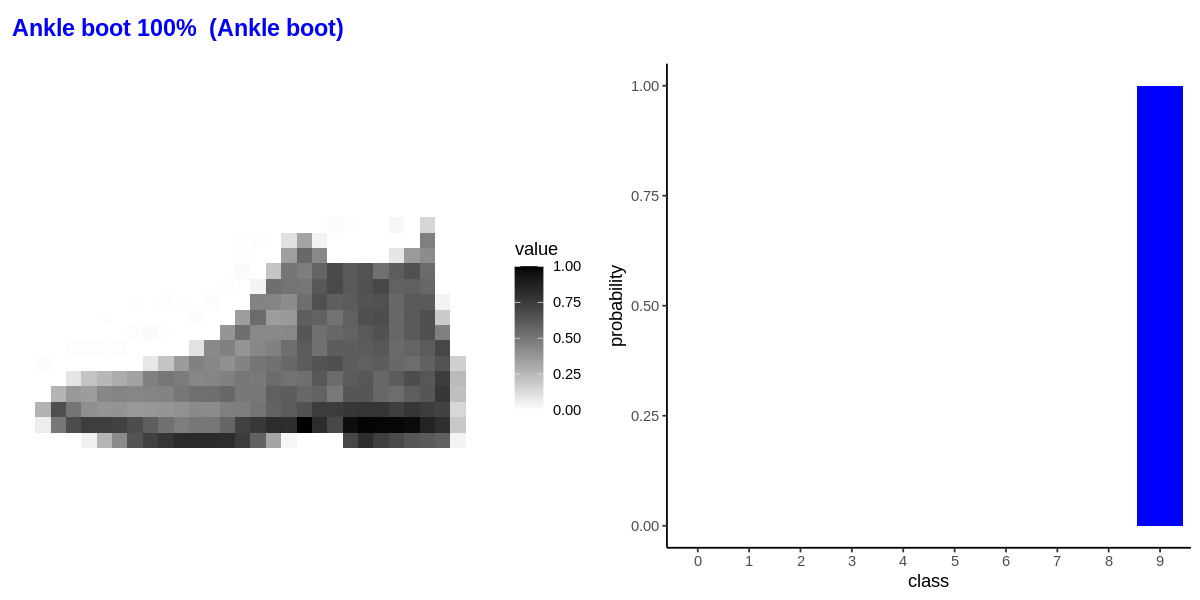

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5)
i <- 1
plot_preds(pred_images[i,,,], preds_probs[i,], pred_labels[i], class_names)

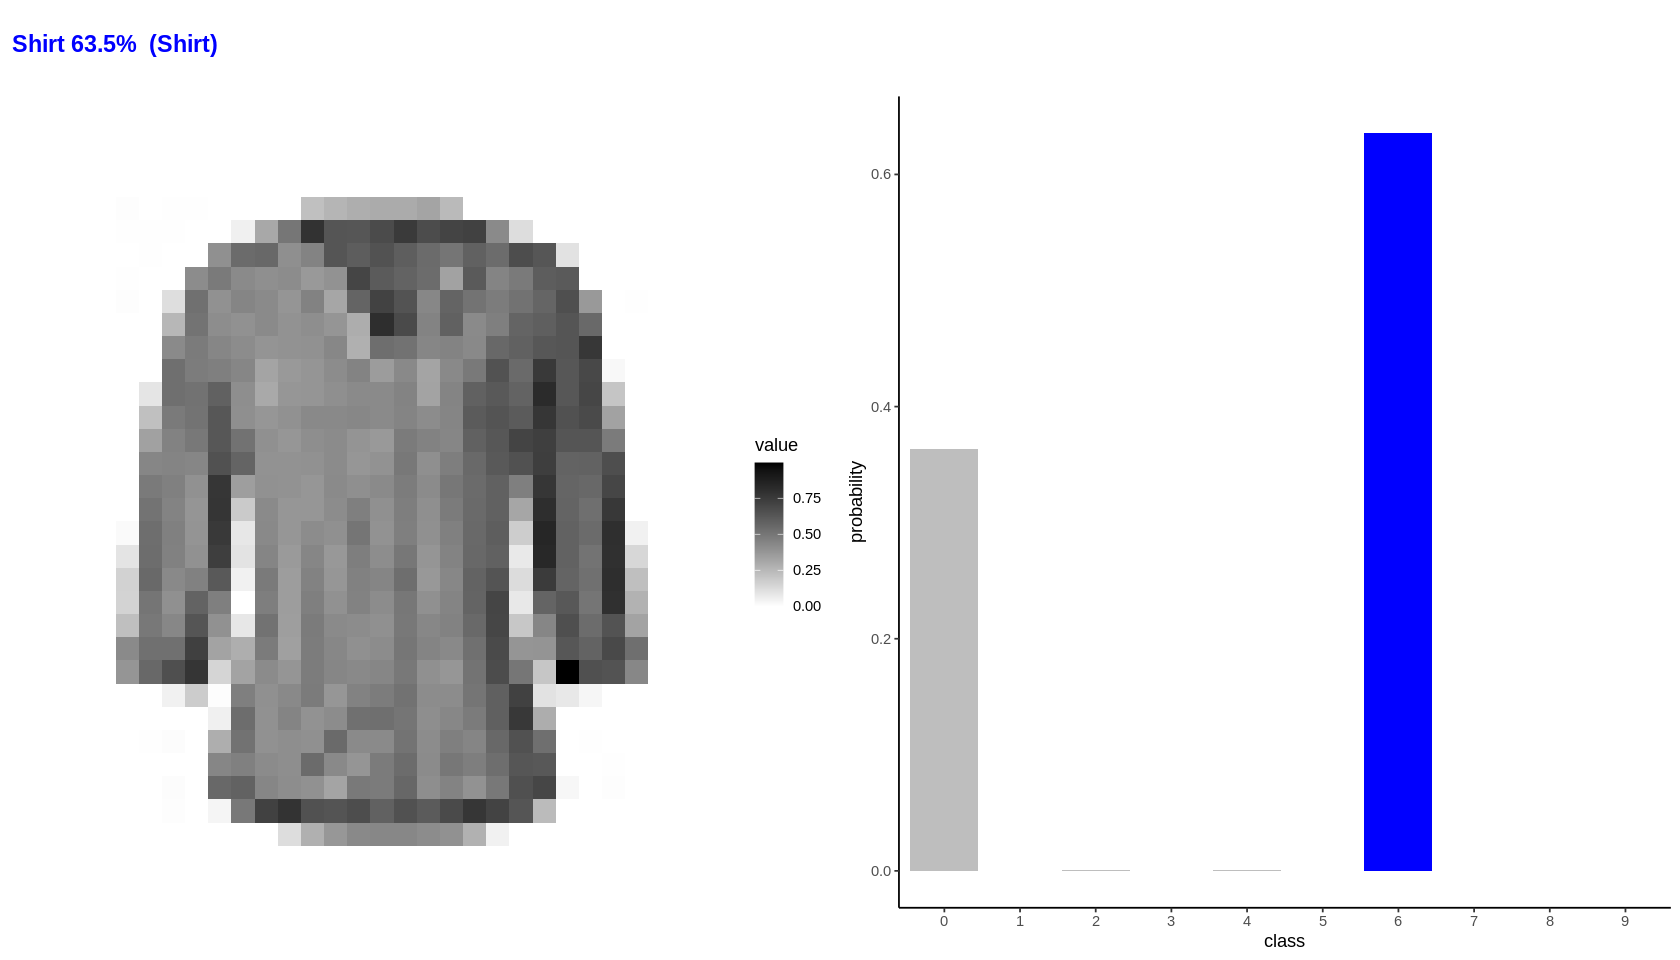

In [ ]:
i <- 5
plot_preds(pred_images[i,,,], preds_probs[i,], pred_labels[i], class_names)

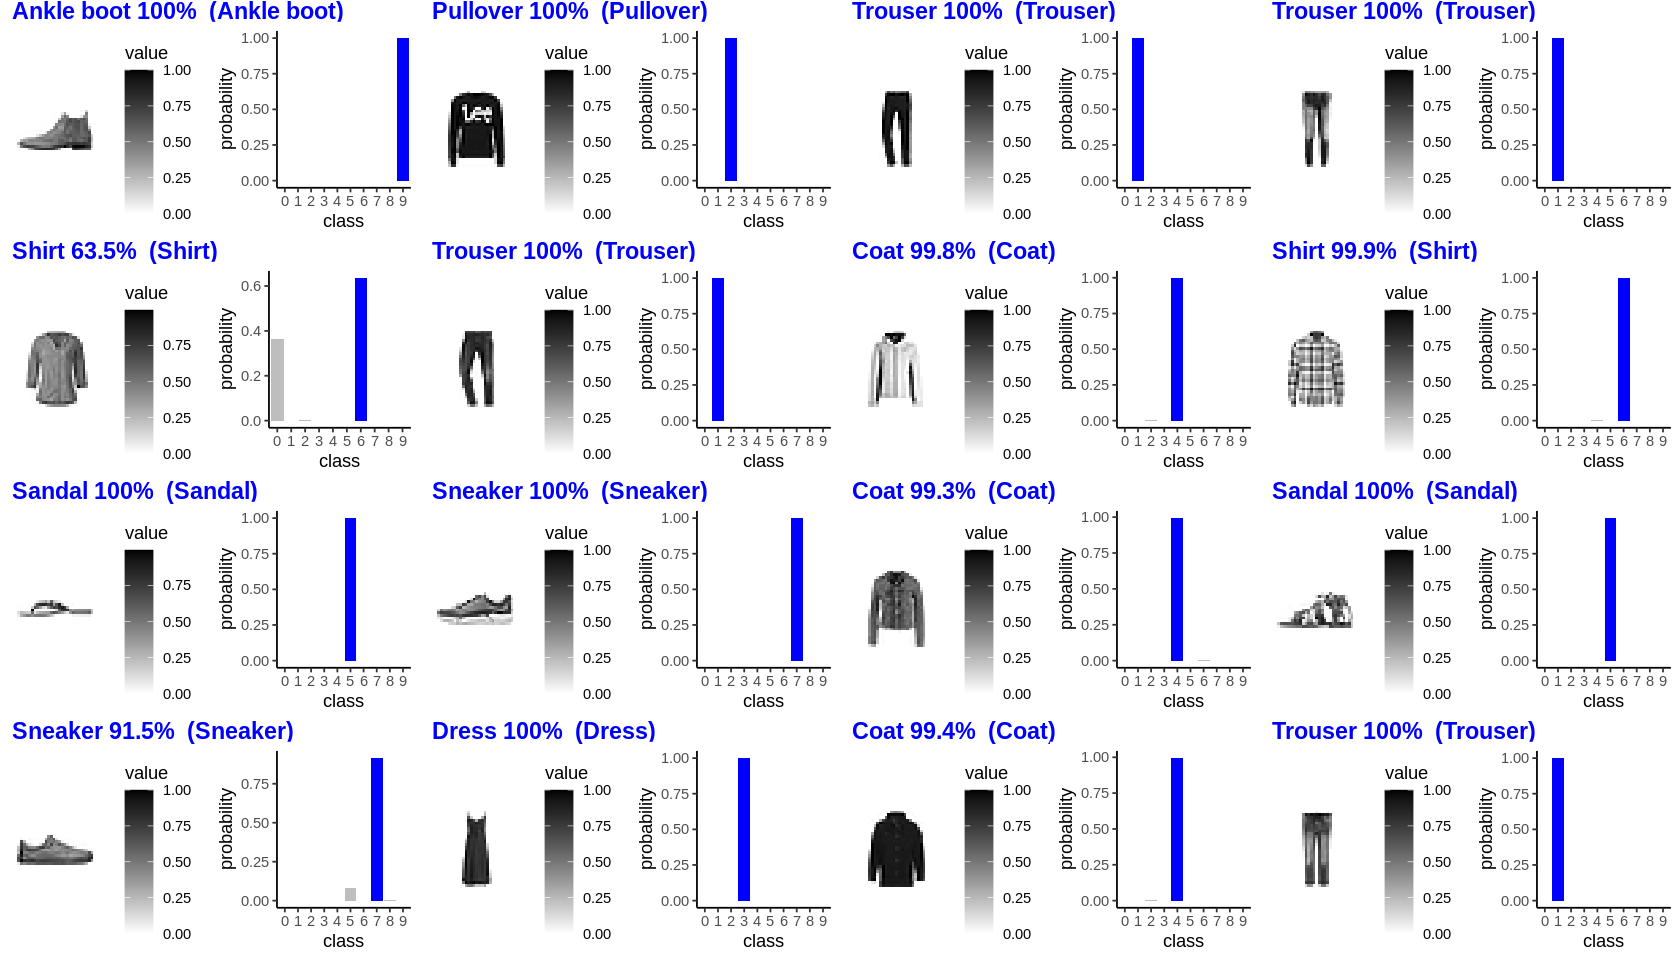

In [ ]:
options(repr.plot.width = 14, repr.plot.height = 8)
  j <- 16
  plot_list <- as.list(vector(length = j))
  for(i in 1:j){
    plot_list[[i]]<- plot_preds(pred_images[i,,,], preds_probs[i,], 
                                pred_labels[i], class_names)
  }
  plot_grid(plotlist = plot_list, ncol = 4)

Finally, use the trained model to make a prediction about a single image.

In [ ]:
image <- test_images[1,,,,drop = FALSE]

In [ ]:
preds_class_single <- model %>% predict_classes(image)

preds_class_single

[1] 9

And, as before, the model predicts a label of 9 (Ankle boot).

# Exercises

Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) and then high, up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final Dense(10), experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has


Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes